In [17]:
import torch
import torch.nn as nn
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import deque
import cv2
import time
from pathlib import Path
from IPython.display import clear_output

In [18]:
import ale_py
gym.register_envs(ale_py)

# VISUALIZATION CONFIGURATION PARAMETERS
VISUALIZATION_FRAME_SKIP = 10  # Show every Nth step (10 = show every 10th step)
# VISUALIZATION_FRAME_SKIP = 5   # More frequent visualization
# VISUALIZATION_FRAME_SKIP = 20  # Less frequent visualization
# VISUALIZATION_FRAME_SKIP = 1   # Show every single step (warning: very slow!)

In [19]:
class ConvDQN_CNN1(nn.Module):
    """Original CNN architecture (32->64->64 filters)"""
    def __init__(self, input_channels, action_size):
        super(ConvDQN_CNN1, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=8, stride=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        self.feature_size = self._get_conv_output_size()
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(),
            nn.Linear(512, action_size)
        )
    
    def _get_conv_output_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 2, 84, 84)
            conv_output = self.conv(dummy_input)
            return conv_output.numel() // conv_output.size(0)
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class ConvDQN_CNN2(nn.Module):
    """Optimized CNN architecture (32->36->20 filters)"""
    def __init__(self, input_channels, action_size):
        super(ConvDQN_CNN2, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=8, stride=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 36, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(36, 20, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        self.feature_size = self._get_conv_output_size()
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(),
            nn.Linear(512, action_size)
        )
    
    def _get_conv_output_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 2, 84, 84)
            conv_output = self.conv(dummy_input)
            return conv_output.numel() // conv_output.size(0)
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def preprocess_frame(frame):
    gray = np.mean(frame, axis=2).astype(np.uint8)
    cropped = gray[34:194, :]
    resized = cv2.resize(cropped, (84, 84), interpolation=cv2.INTER_AREA)
    return resized.astype(np.float32) / 255.0

class FrameStack:
    def __init__(self, num_frames=2):
        self.num_frames = num_frames
        self.frames = deque(maxlen=num_frames)
    
    def reset(self, frame):
        processed_frame = preprocess_frame(frame)
        for _ in range(self.num_frames):
            self.frames.append(processed_frame)
        return self.get_stacked()
    
    def step(self, frame):
        processed_frame = preprocess_frame(frame)
        self.frames.append(processed_frame)
        return self.get_stacked()
    
    def get_stacked(self):
        return np.stack(list(self.frames), axis=0)

In [20]:
def find_latest_run_checkpoints():
    """Find checkpoints from the most recent training run"""
    artifacts_dir = Path.home() / "dev" / "rl_study" / "artifacts"
    
    run_dirs = [d for d in artifacts_dir.glob("run_*") if d.is_dir()]
    
    if not run_dirs:
        return []
    
    latest_run_dir = max(run_dirs, key=lambda d: d.stat().st_mtime)
    print(f"Latest run: {latest_run_dir.name}")
    
    checkpoint_files = list(latest_run_dir.glob("*checkpoint*.pth"))
    
    checkpoints = []
    for file_path in checkpoint_files:
        checkpoints.append({
            'path': str(file_path),
            'filename': file_path.name,
            'run_dir': latest_run_dir.name
        })
    
    # Sort checkpoints by episode number extracted from filename
    def extract_episode_or_step_number(checkpoint):
        """Extract episode or step number from various filename formats"""
        filename = checkpoint['filename']
        try:
            # Try episode format first: "pong_dqn_cnn_checkpoint_ep1000.pth" or "pong_dqn_cnn_v2_checkpoint_ep1000.pth"
            if 'ep' in filename:
                ep_start = filename.find('ep') + 2
                ep_end = filename.find('.pth')
                if ep_end > ep_start:
                    return int(filename[ep_start:ep_end])
            
            # Try step format: "pong_dqn_cnn_checkpoint_step5000.pth" or "pong_dqn_cnn_v2_checkpoint_step5000.pth"  
            if 'step' in filename:
                step_start = filename.find('step') + 4
                step_end = filename.find('.pth')
                if step_end > step_start:
                    return int(filename[step_start:step_end])
            
            # Try episode_: "pong_dqn_cnn_checkpoint_episode_1000.pth"
            if 'episode_' in filename:
                ep_start = filename.find('episode_') + 8
                ep_end = filename.find('.pth')
                if ep_end > ep_start:
                    return int(filename[ep_start:ep_end])
                    
            return 0  # Default for files without recognizable numbers
        except (ValueError, AttributeError):
            return 0  # Default for files that can't be parsed
    
    # Sort by episode/step number
    checkpoints.sort(key=extract_episode_or_step_number)
    
    return checkpoints

def detect_model_architecture(checkpoint_path):
    """Automatically detect model architecture from checkpoint"""
    try:
        device = torch.device("cpu")  # Load on CPU first for inspection
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        
        # Try to determine architecture from the model state dict
        state_dict = checkpoint['model_state_dict']
        
        # Check the shape of the second conv layer to distinguish architectures
        if 'conv.2.weight' in state_dict:
            conv2_shape = state_dict['conv.2.weight'].shape
            if conv2_shape[0] == 64:  # 64 output channels = original architecture
                return "cnn1", "Original (32→64→64)"
            elif conv2_shape[0] == 36:  # 36 output channels = v2 architecture
                return "cnn2", "Optimized v2 (32→36→20)"
        
        # Fallback: try to guess from filename
        filename = Path(checkpoint_path).name.lower()
        if 'v2' in filename:
            return "cnn2", "Optimized v2 (32→36→20)"
        else:
            return "cnn1", "Original (32→64→64)"
            
    except Exception as e:
        print(f"Warning: Could not detect architecture from {checkpoint_path}: {e}")
        return "cnn1", "Original (32→64→64) - Default"

def load_model(checkpoint_path, cnn_type=None):
    """Load model from checkpoint with auto-detection or specified CNN architecture
    
    Args:
        checkpoint_path: Path to checkpoint file
        cnn_type: Either 'cnn1' for original, 'cnn2' for optimized, or None for auto-detection
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    
    # Auto-detect architecture if not specified
    if cnn_type is None:
        cnn_type, arch_name = detect_model_architecture(checkpoint_path)
    else:
        # Use specified architecture
        if cnn_type.lower() == "cnn1":
            arch_name = "Original (32→64→64)"
        elif cnn_type.lower() == "cnn2":
            arch_name = "Optimized v2 (32→36→20)"
        else:
            raise ValueError(f"Unknown CNN type: {cnn_type}. Use 'cnn1', 'cnn2', or None for auto-detection")
    
    # Create model with detected/specified architecture
    if cnn_type.lower() == "cnn1":
        model = ConvDQN_CNN1(input_channels=2, action_size=6).to(device)
    elif cnn_type.lower() == "cnn2":
        model = ConvDQN_CNN2(input_channels=2, action_size=6).to(device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Extract metadata with better handling of different checkpoint formats
    metadata = {
        'episode': checkpoint.get('episode', checkpoint.get('total_steps', 'unknown')),
        'avg_reward': checkpoint.get('avg_reward', 'unknown'),
        'epsilon': checkpoint.get('epsilon', 'unknown'),
        'architecture': arch_name,
        'run_id': checkpoint.get('run_id', 'unknown'),
        'total_steps': checkpoint.get('total_steps', 'unknown')
    }
    
    return model, metadata, device

In [21]:
def visualize_game_frame(raw_frame, processed_frame, stacked_frames, q_values, action, reward, step, total_reward, checkpoint_name, architecture):
    """Show the current game state and agent decision with fixed layout"""
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f'{checkpoint_name} ({architecture}) - Step {step} - Action: {action}, Step Reward: {reward:.1f}, Total: {total_reward:.1f}', 
                 fontsize=14, fontweight='bold')
    
    # Raw game frame - FIXED SIZE
    axes[0].imshow(raw_frame)
    axes[0].set_title('Raw Game Frame')
    axes[0].axis('off')
    # Fix the aspect ratio and size
    axes[0].set_aspect('equal')
    
    # Processed frame that agent sees - FIXED SIZE
    axes[1].imshow(processed_frame, cmap='gray')
    axes[1].set_title('Processed Frame (84x84)')
    axes[1].axis('off')
    # Fix the aspect ratio and size
    axes[1].set_aspect('equal')
    
    # Q-values with FIXED AXES and POSITION
    actions = ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
    colors = ['red' if i == action else 'blue' for i in range(len(q_values))]
    
    # Create bars with fixed positions
    x_positions = np.arange(len(q_values))
    bars = axes[2].bar(x_positions, q_values, color=colors, alpha=0.7, width=0.8)
    
    # FIXED AXES LIMITS - prevents movement and resizing
    axes[2].set_ylim(-5, 5)  # Fixed Y range for Q-values
    axes[2].set_xlim(-0.5, len(q_values) - 0.5)  # Fixed X range
    
    axes[2].set_title('Q-Values (Selected Action in Red)')
    axes[2].set_xlabel('Actions')
    axes[2].set_ylabel('Q-Value')
    axes[2].set_xticks(x_positions)
    axes[2].set_xticklabels(actions, rotation=45, fontsize=10)
    axes[2].grid(True, alpha=0.3)
    
    # Add horizontal line at y=0 for reference
    axes[2].axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
    
    # Add value labels with fixed positioning
    for i, (bar, val) in enumerate(zip(bars, q_values)):
        # Position text at fixed height relative to bar
        text_y = max(val + 0.1, -4.8) if val >= 0 else min(val - 0.1, 4.8)
        axes[2].text(bar.get_x() + bar.get_width()/2., text_y,
                    f'{val:.2f}', ha='center', va='bottom' if val >= 0 else 'top', 
                    fontweight='bold' if i == action else 'normal',
                    fontsize=9)
    
    # Frame difference (movement detection) - FIXED SIZE
    frame_diff = np.abs(stacked_frames[1] - stacked_frames[0])
    axes[3].imshow(frame_diff, cmap='hot', vmin=0, vmax=1)  # Fixed color scale
    axes[3].set_title('Movement Detection')
    axes[3].axis('off')
    # Fix the aspect ratio and size
    axes[3].set_aspect('equal')
    
    # Set fixed positions for all subplots to prevent movement
    for i, ax in enumerate(axes):
        pos = ax.get_position()
        # Set fixed subplot positions
        if i == 0:
            ax.set_position([0.05, 0.1, 0.2, 0.8])  # Raw frame
        elif i == 1:
            ax.set_position([0.27, 0.1, 0.2, 0.8])  # Processed frame
        elif i == 2:
            ax.set_position([0.50, 0.1, 0.25, 0.8])  # Q-values (slightly wider)
        elif i == 3:
            ax.set_position([0.77, 0.1, 0.2, 0.8])  # Movement detection
    
    # Force the figure to maintain its size
    plt.subplots_adjust(left=0.05, right=0.98, top=0.85, bottom=0.15)
    plt.show()

In [22]:
def play_and_visualize_game(model, device, checkpoint_name, architecture):
    """Play one complete game and show frames based on VISUALIZATION_FRAME_SKIP parameter"""
    env = gym.make('PongNoFrameskip-v4')
    
    print(f"Playing game with {checkpoint_name} using {architecture}")
    print(f"Showing every {VISUALIZATION_FRAME_SKIP} step(s) of the game")
    print("=" * 60)
    
    state, _ = env.reset()
    frame_stack = FrameStack(2)
    stacked_state = frame_stack.reset(state)
    
    total_reward = 0
    step_count = 0
    done = False
    
    while not done:
        # Get action from model
        with torch.no_grad():
            state_tensor = torch.FloatTensor(stacked_state).unsqueeze(0).to(device)
            q_values = model(state_tensor)
            action = q_values.max(1)[1].item()
            q_vals_numpy = q_values.cpu().numpy()[0]
        
        # Execute action with frame skipping (4 frames as used in training)
        step_reward = 0
        for _ in range(4):  # Frame skip during game execution (same as training)
            next_state, reward, terminated, truncated, _ = env.step(action)
            step_reward += reward
            if terminated or truncated:
                break
        
        done = terminated or truncated
        total_reward += step_reward
        
        # Show visualization based on VISUALIZATION_FRAME_SKIP parameter
        if step_count % VISUALIZATION_FRAME_SKIP == 0:
            processed_current = preprocess_frame(next_state)
            clear_output(wait=True)
            visualize_game_frame(
                raw_frame=next_state,
                processed_frame=processed_current,
                stacked_frames=stacked_state,
                q_values=q_vals_numpy,
                action=action,
                reward=step_reward,
                step=step_count,
                total_reward=total_reward,
                checkpoint_name=checkpoint_name,
                architecture=architecture
            )
            
            print(f"Step {step_count}: Action={action}, Reward={step_reward:.1f}, Total={total_reward:.1f}")
            
            # Adaptive delay based on frame skip - more frequent = shorter delay
            delay_time = max(0.1, min(0.5, VISUALIZATION_FRAME_SKIP * 0.02))
            time.sleep(delay_time)
        
        # Update state
        stacked_state = frame_stack.step(next_state)
        step_count += 1
    
    env.close()
    
    print(f"\nGame finished!")
    print(f"Final reward: {total_reward}")
    print(f"Game length: {step_count} steps")
    print(f"Frames visualized: {(step_count // VISUALIZATION_FRAME_SKIP) + 1}")
    print("=" * 60)
    
    return total_reward, step_count

In [23]:
# Find and display available checkpoints
checkpoints = find_latest_run_checkpoints()

if checkpoints:
    print(f"Found {len(checkpoints)} checkpoints from latest run:")
    for i, cp in enumerate(checkpoints):
        print(f"{i}: {cp['filename']}")
else:
    print("No checkpoints found. Run training first!")

Latest run: run_b507a9719b0f49a18bbe0b0be2835284
Found 7 checkpoints from latest run:
0: pong_dqn_cnn_enhanced_checkpoint_ep0.pth
1: pong_dqn_cnn_enhanced_checkpoint_ep10000.pth
2: pong_dqn_cnn_enhanced_checkpoint_ep20000.pth
3: pong_dqn_cnn_enhanced_checkpoint_ep30000.pth
4: pong_dqn_cnn_enhanced_checkpoint_ep40000.pth
5: pong_dqn_cnn_enhanced_checkpoint_ep50000.pth
6: pong_dqn_cnn_enhanced_checkpoint_ep60000.pth


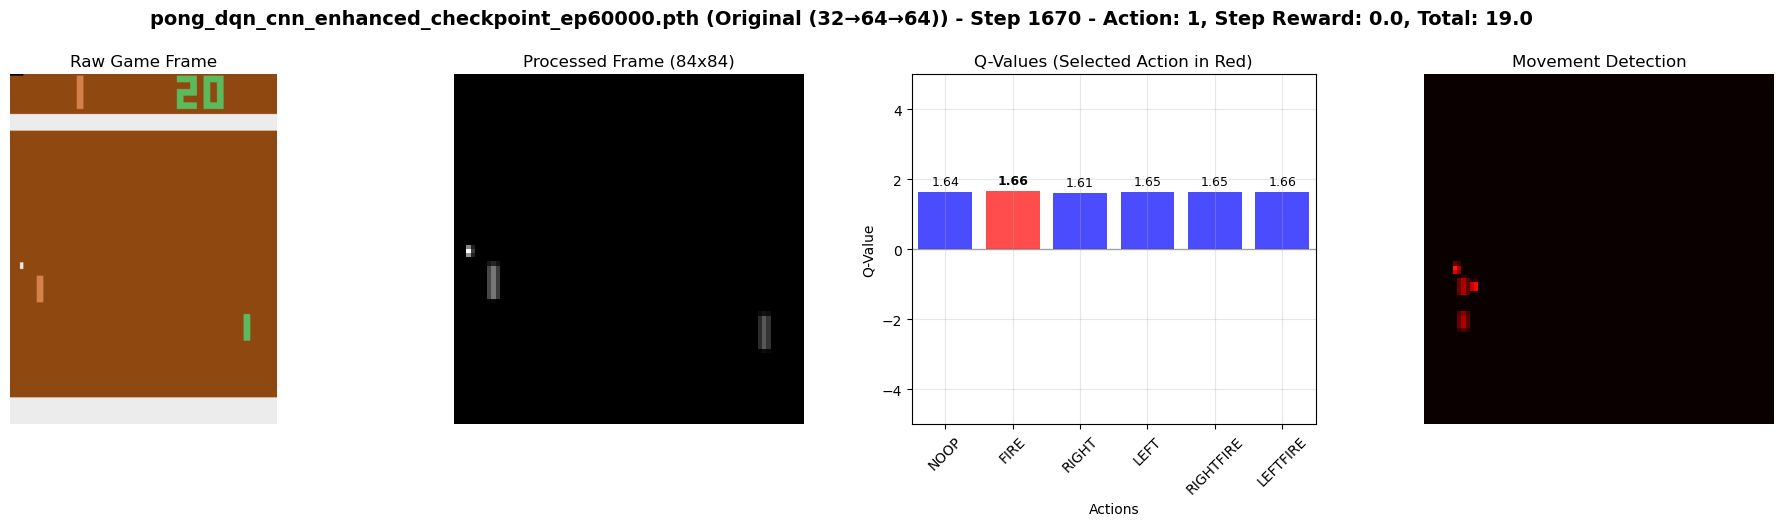

Step 1670: Action=1, Reward=0.0, Total=19.0

Game finished!
Final reward: 20.0
Game length: 1672 steps
Frames visualized: 168

COMPREHENSIVE ANALYSIS SUMMARY
Checkpoint                          Architecture              Train Ep   Train Avg  Game Reward  Game Length 
----------------------------------------------------------------------------------------------------
pong_dqn_cnn_enhanced_checkpoint_ep0.pth Original (32→64→64)       0          -19.0      -21.0        764         
pong_dqn_cnn_enhanced_checkpoint_ep10000.pth Original (32→64→64)       10000      -19.2      -21.0        801         
pong_dqn_cnn_enhanced_checkpoint_ep20000.pth Original (32→64→64)       20000      -12.5      -21.0        2604        
pong_dqn_cnn_enhanced_checkpoint_ep30000.pth Original (32→64→64)       30000      -4.2       1.0          3206        
pong_dqn_cnn_enhanced_checkpoint_ep40000.pth Original (32→64→64)       40000      11.3       20.0         1751        
pong_dqn_cnn_enhanced_checkpoint_ep50000

In [24]:
# ENHANCED CONFIGURATION: Auto-detect model architecture or specify manually
# Set ARCH = None for auto-detection, or specify "cnn1" or "cnn2" to override
ARCH = None  # Auto-detect architecture from checkpoint (recommended)
# ARCH = "cnn1"  # Force original architecture (32->64->64 filters)  
# ARCH = "cnn2"  # Force optimized architecture (32->36->20 filters)

# Select which checkpoint to analyze
if checkpoints:
    if ARCH is None:
        print("Using AUTO-DETECTION for model architecture")
    else:
        print(f"Using MANUAL architecture selection: {ARCH.upper()}")
    
    print("Available checkpoints (sorted by episode/step number):")
    for i, checkpoint in enumerate(checkpoints):
        # Try to detect architecture for display
        try:
            detected_arch, arch_name = detect_model_architecture(checkpoint['path'])
            print(f"{i}: {checkpoint['filename']} -> {arch_name}")
        except:
            print(f"{i}: {checkpoint['filename']}")
    
    # Select checkpoints to analyze - analyze fewer for step-by-step visualization
    if len(checkpoints) > 10:
        # For many checkpoints, analyze every 10th to avoid too many games
        selected_indices = list(range(0, len(checkpoints), max(1, len(checkpoints) // 10)))
        print(f"\nAnalyzing {len(selected_indices)} checkpoints (evenly distributed): {selected_indices}")
    else:
        # For few checkpoints, analyze all
        selected_indices = list(range(len(checkpoints)))
        print(f"\nAnalyzing all {len(selected_indices)} checkpoints: {selected_indices}")
    
    print("=" * 80)
    
    results = []
    
    for idx in selected_indices:
        checkpoint = checkpoints[idx]
        print(f"\n{'='*80}")
        print(f"ANALYZING CHECKPOINT {idx}: {checkpoint['filename']}")
        print(f"{'='*80}")
        
        try:
            # Load model with auto-detection or manual architecture selection
            model, metadata, device = load_model(checkpoint['path'], cnn_type=ARCH)
            
            print(f"Detected Architecture: {metadata['architecture']}")
            print(f"Training Episode: {metadata['episode']}")
            print(f"Training Avg Reward: {metadata['avg_reward']}")
            print(f"Training Epsilon: {metadata['epsilon']}")
            if metadata['total_steps'] != 'unknown':
                print(f"Total Training Steps: {metadata['total_steps']}")
            if metadata['run_id'] != 'unknown':
                print(f"Run ID: {metadata['run_id']}")
            print()
            
            # Play one complete game and visualize every 10th step
            final_reward, game_length = play_and_visualize_game(
                model, device, checkpoint['filename'], metadata['architecture']
            )
            
            # Store results
            results.append({
                'checkpoint': checkpoint['filename'],
                'architecture': metadata['architecture'],
                'training_episode': metadata['episode'],
                'training_avg_reward': metadata['avg_reward'],
                'training_epsilon': metadata['epsilon'],
                'game_reward': final_reward,
                'game_length': game_length,
                'total_steps': metadata['total_steps']
            })
            
        except Exception as e:
            print(f"Error with checkpoint {checkpoint['filename']}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    # Enhanced summary of results
    if results:
        print(f"\n{'='*100}")
        print("COMPREHENSIVE ANALYSIS SUMMARY")
        print(f"{'='*100}")
        print(f"{'Checkpoint':<35} {'Architecture':<25} {'Train Ep':<10} {'Train Avg':<10} {'Game Reward':<12} {'Game Length':<12}")
        print("-" * 100)
        
        for result in results:
            print(f"{result['checkpoint']:<35} {result['architecture']:<25} {str(result['training_episode']):<10} "
                  f"{str(result['training_avg_reward']):<10} {result['game_reward']:<12.1f} {result['game_length']:<12}")
        
        # Calculate averages
        avg_game_reward = sum(r['game_reward'] for r in results) / len(results)
        avg_game_length = sum(r['game_length'] for r in results) / len(results)
        
        print("-" * 100)
        print(f"{'AVERAGES':<35} {'':<25} {'':<10} {'':<10} {avg_game_reward:<12.1f} {avg_game_length:<12.1f}")
        print()
        
        # Show architecture distribution
        arch_counts = {}
        for result in results:
            arch = result['architecture']
            arch_counts[arch] = arch_counts.get(arch, 0) + 1
        
        print("Architecture Distribution:")
        for arch, count in arch_counts.items():
            print(f"  {arch}: {count} checkpoint(s)")
            
else:
    print("No checkpoints available to analyze!")
    print("Make sure to run training first with either pong_dqn_cnn.ipynb or pong_dqn_cnn_v2.ipynb")